# Test basic random optimization routines

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns

from types import SimpleNamespace
from tqdm.notebook import tqdm

from bioslds.hyperopt import random_maximize
from bioslds.plotting import FigureManager, colorbar

## Test `random_maximize`

### Use as a naive linear regression algorithm

In [2]:
rng = np.random.default_rng(1)
naive_reg = SimpleNamespace(n=100, a=0.3, x_range=(-1, 1), sigma=0.05, n_iter=10000)
naive_reg.x = np.linspace(*naive_reg.x_range, naive_reg.n)
naive_reg.y = naive_reg.a * naive_reg.x + naive_reg.sigma * rng.normal(size=naive_reg.n)

naive_reg.fct = lambda slope: -np.sum((naive_reg.y - slope * naive_reg.x) ** 2)
naive_reg.opt_res = random_maximize(
    naive_reg.fct, {"slope": (-1.0, 1.0)}, naive_reg.n_iter
)

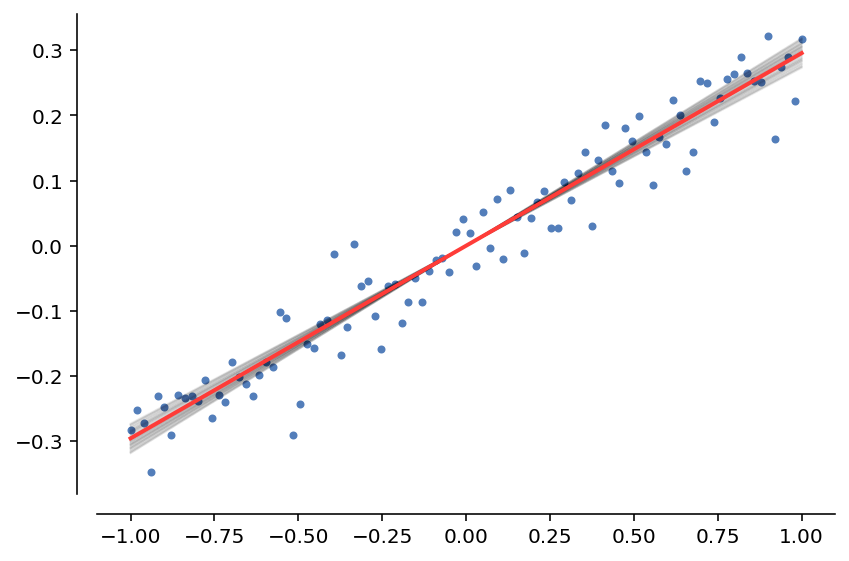

In [3]:
with FigureManager() as (_, ax):
    ax.plot(naive_reg.x, naive_reg.y, ".")

    crt_best_slope = naive_reg.opt_res[1]["slope"]
    crt_good_mask = (
        np.asarray(naive_reg.opt_res[2]["fct_scalar"]) > 1.1 * naive_reg.opt_res[0]
    )

    crt_all_slopes = np.asarray([_["slope"] for _ in naive_reg.opt_res[2]["params"]])
    crt_good_slopes = crt_all_slopes[crt_good_mask]
    crt_x_ends = naive_reg.x[[0, -1]]
    for crt_slope in crt_good_slopes:
        ax.plot(crt_x_ends, crt_slope * crt_x_ends, lw=1, c="k", alpha=0.01)
        
    ax.plot(crt_x_ends, crt_best_slope * crt_x_ends, lw=2, c="C1")

### Use with several parameters and progress bar

In [4]:
rng = np.random.default_rng(0)
multi_param = SimpleNamespace(
    t_max=50.0,
    dt=0.1,
    period=5.3,
    damp_time=20.0,
    amplitude=2.0,
    sigma=0.15,
    n_iter=100000,
)
multi_param.n = int(multi_param.t_max / multi_param.dt)
multi_param.t = np.arange(multi_param.n) * multi_param.dt
multi_param.y0 = (
    multi_param.amplitude
    * np.exp(-multi_param.t / multi_param.damp_time)
    * np.cos(2 * np.pi * multi_param.t / multi_param.period)
)
multi_param.y = multi_param.y0 + multi_param.sigma * rng.normal(size=multi_param.n)

In [5]:
multi_param.approx_fct = (
    lambda amplitude, damp_time, period, t: amplitude
    * np.exp(-t / damp_time)
    * np.cos(2 * np.pi / period * t)
)
rms = lambda v: np.sum(v ** 2)
multi_param.fct = lambda amplitude, damp_time, period: -rms(
    multi_param.y - multi_param.approx_fct(amplitude, damp_time, period, multi_param.t)
)
multi_param.param_ranges = {
    "amplitude": (1.0, 3.0),
    "damp_time": (10.0, 30.0),
    "period": (1.0, 10.0),
}
multi_param.opt_res = random_maximize(
    multi_param.fct, multi_param.param_ranges, multi_param.n_iter, progress=tqdm,
)

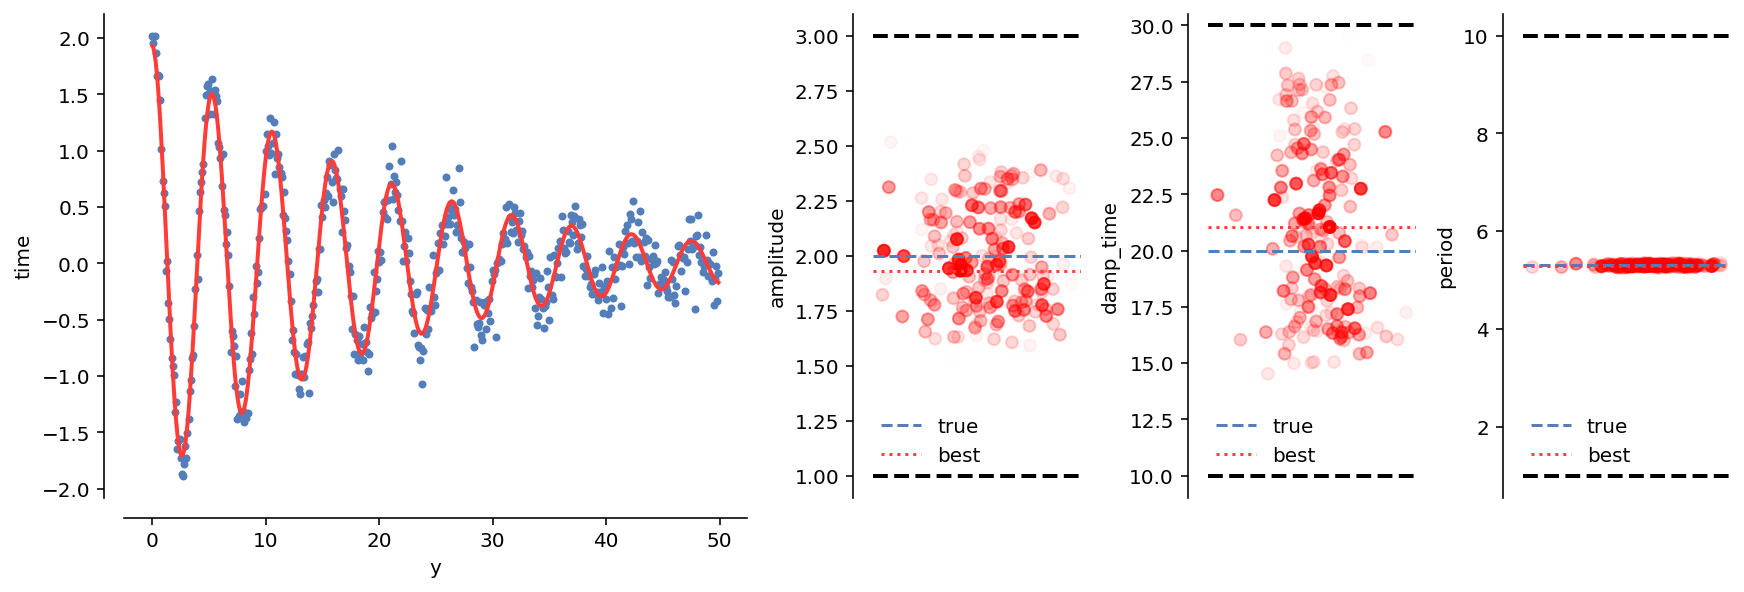

In [6]:
with FigureManager(
    1,
    4,
    constrained_layout=True,
    gridspec_kw={"width_ratios": (3, 1, 1, 1)},
    figsize=(12, 4),
) as (_, axs):
    axs[0].plot(multi_param.t, multi_param.y, ".")

    crt_best_params = multi_param.opt_res[1]
    crt_best_approx = multi_param.approx_fct(**crt_best_params, t=multi_param.t)
    axs[0].plot(multi_param.t, crt_best_approx, lw=2, c="C1")

    axs[0].set_xlabel("y")
    axs[0].set_ylabel("time")

    crt_fct_values = np.asarray(multi_param.opt_res[2]["fct_scalar"])
    crt_best_fct = multi_param.opt_res[0]
    crt_fct_range = 0.5 * multi_param.n * multi_param.sigma ** 2
    crt_alpha = 1 - np.clip(
        np.sqrt((crt_best_fct - crt_fct_values) / crt_fct_range), 0, 1
    )
    crt_colors = np.zeros((len(crt_alpha), 4))
    crt_colors[:, 0] = 1.0
    crt_colors[:, -1] = crt_alpha

    crt_mask = crt_alpha > 0
    crt_colors_masked = crt_colors[crt_mask, :]

    rng = np.random.default_rng(0)
    for i, crt_var in enumerate(multi_param.param_ranges):
        ax = axs[i + 1]
        crt_values = np.asarray([_[crt_var] for _ in multi_param.opt_res[2]["params"]])
        crt_values = crt_values[crt_mask]

        ax.scatter(rng.normal(size=len(crt_values)), crt_values, c=crt_colors_masked)
        ax.set_ylabel(crt_var)

        crt_true_value = getattr(multi_param, crt_var)
        ax.axhline(crt_true_value, c="C0", ls="--", label="true")

        crt_best_value = multi_param.opt_res[1][crt_var]
        ax.axhline(crt_best_value, c="C1", ls=":", label="best")

        crt_range = multi_param.param_ranges[crt_var]
        ax.axhline(crt_range[0], ls="--", c="k", lw=2)
        ax.axhline(crt_range[1], ls="--", c="k", lw=2)

        ax.legend(frameon=False, loc=(0, 0.05))

# this needs to be done outside of FigureManager, otherwise despine messes with it
for ax in axs[1:]:
    ax.get_xaxis().set_visible(False)
    ax.spines["bottom"].set_visible(False)

## Test distribution of generated parameters

In [7]:
rng = np.random.default_rng(1)
dist_test = SimpleNamespace(
    real_lin_range=(1.4, 3.6),
    real_log_range=(0.5, 5.0),
    int_range=(1, 10),
    n_iter=1000,
)
_, _, dist_test.details = random_maximize(
    lambda **kwargs: 1.0,
    {
        "real_lin": dist_test.real_lin_range,
        "real_log": dist_test.real_log_range,
        "int": dist_test.int_range,
    },
    dist_test.n_iter,
    log_scale=["real_log"],
    rng=rng,
)

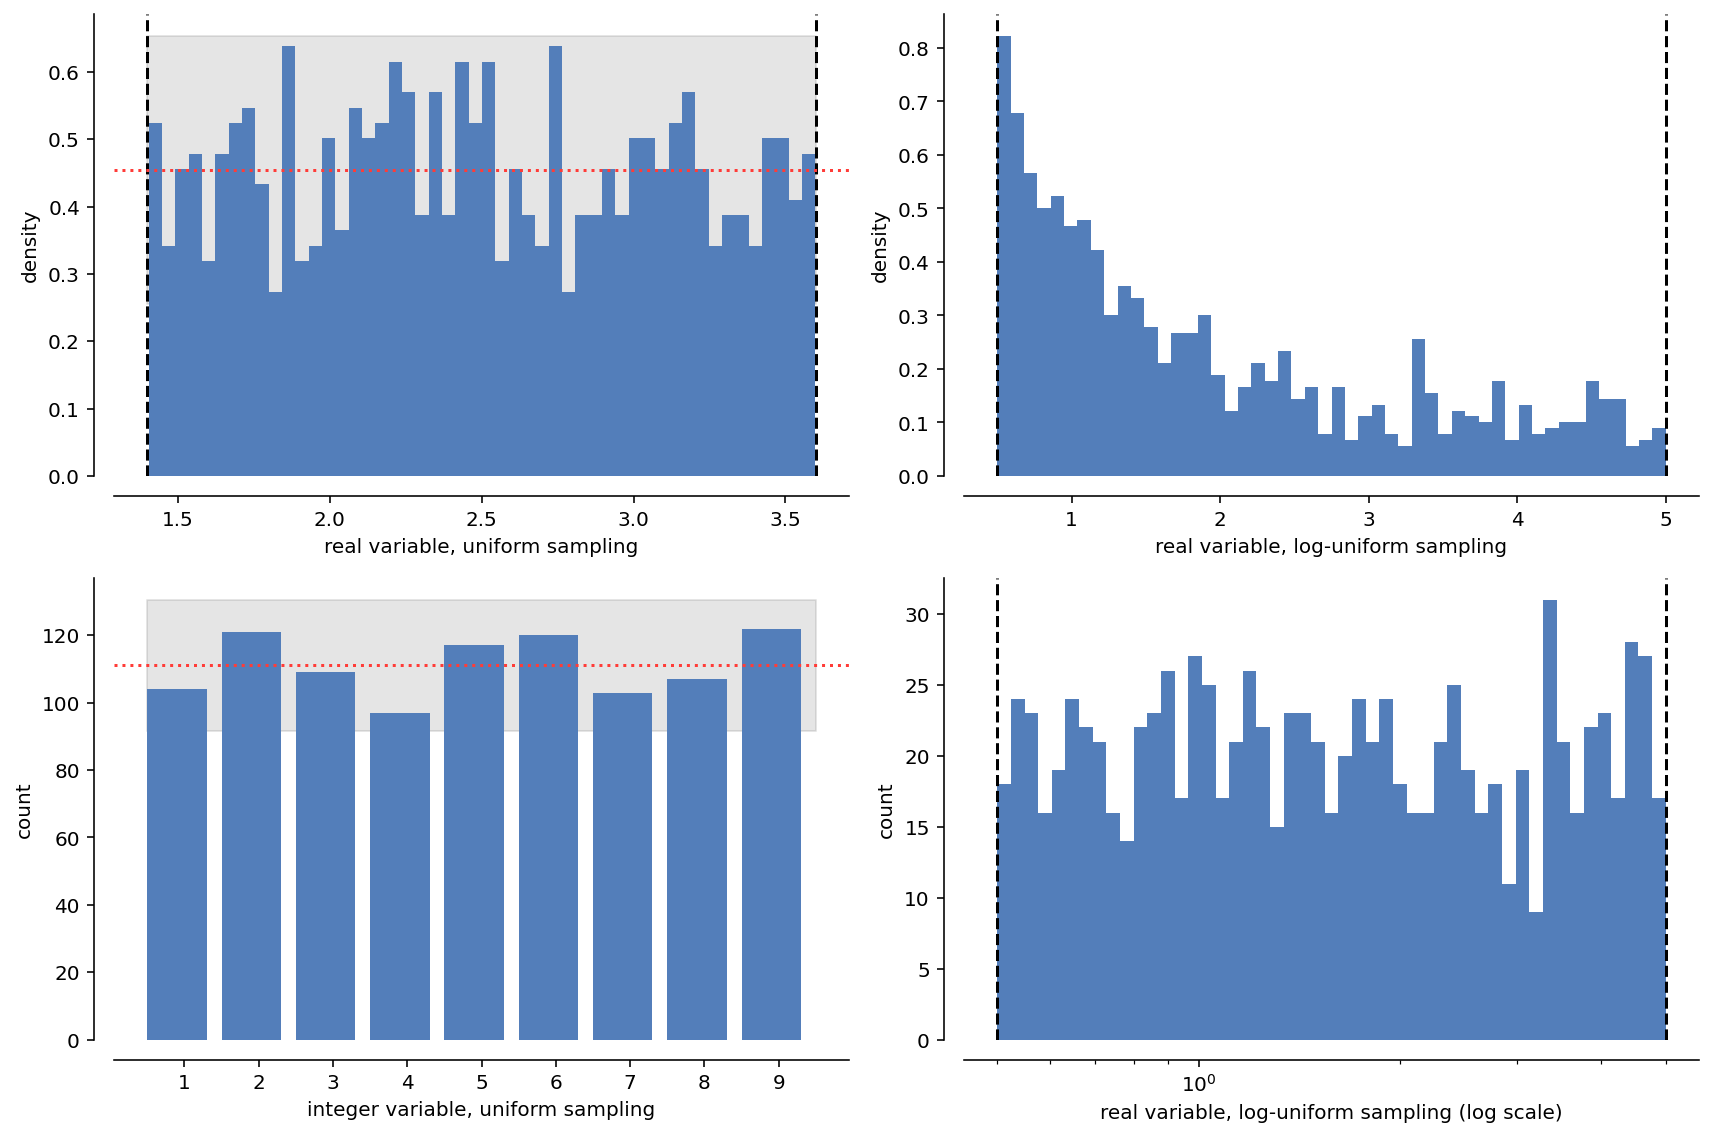

In [8]:
with FigureManager(2, 2) as (_, axs):
    axs = axs.flat

    crt_bins = 50
    axs[0].hist(
        [_["real_lin"] for _ in dist_test.details["params"]], crt_bins, density=True
    )
    axs[0].set_xlabel("real variable, uniform sampling")
    axs[0].set_ylabel("density")

    axs[0].axvline(dist_test.real_lin_range[0], c="k", ls="--")
    axs[0].axvline(dist_test.real_lin_range[1], c="k", ls="--")

    crt_p = 1 / np.diff(dist_test.real_lin_range)
    crt_std = crt_p * np.sqrt(crt_bins / dist_test.n_iter)
    axs[0].axhline(crt_p, c="C1", ls=":")
    axs[0].fill_between(
        dist_test.real_lin_range,
        y1=crt_p - 1.96 * crt_std,
        y2=crt_p + 1.96 * crt_std,
        color="gray",
        alpha=0.2,
    )

    axs[1].hist([_["real_log"] for _ in dist_test.details["params"]], 50, density=True)
    axs[1].set_xlabel("real variable, log-uniform sampling")
    axs[1].set_ylabel("density")

    axs[1].axvline(dist_test.real_log_range[0], c="k", ls="--")
    axs[1].axvline(dist_test.real_log_range[1], c="k", ls="--")

    crt_bins = np.arange(dist_test.int_range[0], dist_test.int_range[1] + 1) - 0.5
    axs[2].hist([_["int"] for _ in dist_test.details["params"]], crt_bins, width=0.8)
    axs[2].set_xticks(np.arange(*dist_test.int_range))
    axs[2].set_xlabel("integer variable, uniform sampling")
    axs[2].set_ylabel("count")

    crt_mean = dist_test.n_iter / np.diff(dist_test.int_range)
    crt_var = crt_mean * (1 - 1 / np.diff(dist_test.int_range))
    crt_std = np.sqrt(crt_var)
    axs[2].axhline(crt_mean, c="C1", ls=":")
    axs[2].fill_between(
        crt_bins[[0, -1]],
        y1=crt_mean - 1.96 * crt_std,
        y2=crt_mean + 1.96 * crt_std,
        color="gray",
        alpha=0.2,
    )

    crt_bins = np.geomspace(*dist_test.real_log_range, 50)
    axs[3].hist(
        [_["real_log"] for _ in dist_test.details["params"]], crt_bins
    )
    axs[3].set_xlabel("real variable, log-uniform sampling (log scale)")
    axs[3].set_ylabel("count")

    axs[3].set_xscale("log")

    axs[3].axvline(dist_test.real_log_range[0], c="k", ls="--")
    axs[3].axvline(dist_test.real_log_range[1], c="k", ls="--")